In [1]:
import dadrah.analysis.root_plotting_util as rpu
import dadrah.util.run_paths as runpa
import dadrah.util.string_constants as stco
import dadrah.selection.selection_util as seut
import pofah.jet_sample as js
import pofah.phase_space.cut_constants as cuts

import pathlib
import argparse
import scipy
from scipy.stats import kstwo
from scipy.stats import chi2

import numpy as np
import ROOT as rt
import root_numpy as rtnp
import uuid
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)
import cmsstyle #mplhep for Python2 cheatsheet

Welcome to JupyROOT 6.22/00


In [2]:
scipy.__version__

'1.5.1'

## runtime params

### change:

In [37]:
Parameters = recordtype('Parameters','qr_run_n, quantiles, qcd_sample_id, sig_sample_id, sig_xsec, score_strategy_id, read_n,env_run_n, poly_run_n')
params = Parameters(qr_run_n=404,
                    quantiles=[0.3, 0.5, 0.7, 0.9],
                    qcd_sample_id='qcdSigAll', 
                    sig_sample_id='GtoWW35naReco',
                    sig_xsec=0,
                    score_strategy_id='rk5_05',
                    read_n=None,
                    env_run_n=0,
                    poly_run_n=0,
                    )

ae_run_n = 113
#qr_run_n, qr_model_str = 4, 'poly'
#qr_run_n, qr_model_str = 5, 'bernstein'
#qr_run_n, qr_model_str = 7, 'dense'
#qr_run_n, qr_model_str = 7, 'dense_polyfit'
#qr_run_n, qr_model_str = 8, 'dense_70pct_train'
#qr_run_n, qr_model_str, train_share = 31, 'dense_kfold', 0
#qr_run_n, qr_model_str, train_share = 34, 'dense_kfold_lmfit11', 0 # => current best
#qr_run_n, qr_model_str, train_share = 189, 'dense_kfold_binned_ratio', 0
#qr_run_n, qr_model_str, train_share = 191, 'dense_kfold_global_ratio', 0
qr_model_str, train_share = 'kfold_40400', 0

xsec = 0
mX = 3.5
sample_id_qcd = 'qcdSigAllTest'+str(int((1-train_share)*100))+'pct' if train_share else 'qcdSigAll'
sample_id_sig = 'GtoWW35naReco'
sample_ids = [sample_id_qcd, sample_id_sig]
#quantiles = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
#quantiles = [0.3, 0.5, 0.7, 0.9]
#quantiles = [0.5, 0.9]
#quantiles = [0.1, 0.5, 0.99]

# choose which template quantile to use (0 = 0.9-1.0, 1 = 0.7-0.9)
template_q_idx = 0
poly_cut = True

# paths
input_path = kstco.get_polynomials_out_data_dir(params)
fig_dir = 'fig/qr_run_'+str(int(params.qr_run_n))+'/env_run_'+str(int(params.env_run_n))+'/poly_run_'+str(int(params.poly_run_n))
pathlib.Path(fig_dir).mkdir(parents=True, exist_ok=True)

xsecs_sig   = [0,20,40,60,80,100] # signal cross sections

file_name_root_hist = 'histograms_injSig_PDinj_NA3p5_r'+str(qr_run_n)+'.root'
#quants = [0.0, 0.3, 0.5, 0.7, 0.9, 0.99]
quants = [0.0, 0.3, 0.5, 0.7, 0.9]
#quants = [0.0, 0.7]

In [38]:
xsec_train = 0 # signal cross section used when training the QR
mX = 3.5
sample_id_qcd = 'qcdSigAllTest'+str(int((1-train_share)*100))+'pct' if train_share else 'qcdSigAll'
sample_id_sig = 'GtoWW35naReco'
sample_ids = [sample_id_qcd, sample_id_sig]
template_q_idx = 0
quant_tmplt = quants[template_q_idx]

In [39]:
if poly_cut:
    paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections_poly_cut'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
    path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig[:-4], 'xsec': str(int(xsec_train)), 'loss': 'rk5_05', 'order':'5'}
else:
    paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
    path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig, 'xsec': str(int(xsec_train)), 'loss': 'rk5_05'}
paths.extend_in_path_data(path_ext_dict)
paths.extend_out_path_data({**path_ext_dict, 'hypothesis_testing': None})

### fixed

In [40]:
# Rescaling the inputs to lumi
qcd_xsec         = 8730000.0 # Crossection in fb             
qcd_gen_events   = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
sig_xsec_default = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events   = 972050.0 #(all generated signal)
lumi             = qcd_gen_events/qcd_xsec # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = qcd_xsec*lumi/qcd_gen_events
scale_sig = (1-train_share)*sig_xsec_default*lumi/sig_gen_events #X% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale QCD with {}'.format(scale_qcd))
print('Scale signal with {}'.format(scale_sig))

Usign luminosity 63.98123745704467
Scale QCD with 1.0
Scale signal with 0.0006582093252100682


In [41]:
# efficiencies
quants_tmp = np.asarray(quants+[1.])
effs = (quants_tmp)[template_q_idx+1:] - (quants_tmp)[template_q_idx:-1]
effs = effs[1:]/effs[0] # scale down instead of up (apply to template quantile)

In [42]:
effs

array([0.6667, 0.6667, 0.6667, 0.3333])

In [43]:
n_bins = 40
min_mjj = 1200.
max_mjj = 5600.
expo_binning = False
dijet_binning = True


if dijet_binning:
    bin_edges = np.array([1200, 1255, 1320, 1387, 1457, 1529, 1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 4411, 4583, 4760, 4943, 5132, 5327]).astype('float')
    bin_edges = bin_edges[bin_edges>=min_mjj]
elif expo_binning:
    x_shift = 3
    lin_bins = np.linspace(0.,1.,n_bins)
    exp_bins = lin_bins/(np.exp(-lin_bins+x_shift)/np.exp(x_shift-1))
    bin_edges = exp_bins*(max_mjj-min_mjj)+min_mjj
    
else: # simple linear binning
    bin_edges = np.array(np.linspace(min_mjj, max_mjj, n_bins).tolist()).astype('float') #100 GeV binning. Stop at 5600! Fit fails if going to 6800
    
n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

In [44]:
bin_edges

array([1200., 1255., 1320., 1387., 1457., 1529., 1604., 1681., 1761.,
       1844., 1930., 2019., 2111., 2206., 2305., 2406., 2512., 2620.,
       2733., 2849., 2969., 3093., 3221., 3353., 3490., 3632., 3778.,
       3928., 4084., 4245., 4411., 4583., 4760., 4943., 5132., 5327.])

## read histogram data

In [45]:
def read_root_hist_data(file_name):
    
    hist_data = {}
    ff = rt.TFile.Open(file_name,'r')

    # read bins from template quantile
    dat = ff.Get('data_acc_{}fb_q{}p'.format(0,int(100))); dat.SetDirectory(0);
    bin_centers = np.asarray([dat.GetXaxis().GetBinCenter(j) for j in range(1,dat.GetNbinsX()+1)])

    # for each quantile
    for i, quant in enumerate(quants):

        hist_data_quant = {}
        q_key = quants[i]*100

        # for each signal injection
        for xsec in xsecs_sig:

            dat = ff.Get('data_acc_{}fb_q{}p'.format(xsec,int(q_key))); dat.SetDirectory(0);
            yy = np.asarray([dat.GetBinContent(j) for j in range(1,dat.GetNbinsX()+1)])

            hist_data_quant[xsec] = yy

        hist_data[quant] = hist_data_quant
        
    return bin_centers, hist_data

In [46]:
def read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths):
    samples = {}

    for sample_id in sample_ids:
        samples[sample_id] = js.JetSample.from_input_file(sample_id, paths.in_file_path(sample_id), **cuts.signalregion_cuts)
        
    # qcd raw data
    samples_ortho_quantiles_qcd = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_qcd], quantiles[1:])
    mjj_vals_qcd = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_qcd]
    # signal raw data
    samples_ortho_quantiles_sig = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_sig], quantiles[1:])
    mjj_vals_sig = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_sig]
    
    return mjj_vals_qcd, mjj_vals_sig

In [47]:
def read_raw_selection_data_to_numpy_hist(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, bin_edges, paths):
    
    mjj_vals_qcd, mjj_vals_sig = read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths)
    
    datas_qcd = {}
    datas_sig = {}
    
    # qcd histogram data
    for mjj, q in zip(mjj_vals_qcd[template_q_idx:], quantiles[template_q_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_qcd[q] = counts
        
    # sig histogram data
    for mjj, q in zip(mjj_vals_sig[template_q_idx:], quantiles[template_q_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_sig[q] = counts
    
    # make signal injection dataset for all signal xsecs
    histos_data_inj = {}
    
     # for each quantile
    for quant in quantiles[template_q_idx:]:
        
        histos_data_inj_quant = {}
        
        # for each signal cross section (each signal injection value)
        for xsec in xsecs_sig:
        
            # get qcd data
            dat = datas_qcd[quant]
            # add signal data according to cross section
            scale_xsec_sig = xsec/sig_xsec_default
            sig_inj = datas_sig[quant]*scale_sig*scale_xsec_sig
            # TODO: sample sig bin height from poisson?
            
            histos_data_inj_quant[xsec] = dat + sig_inj
            
        histos_data_inj[quant] = histos_data_inj_quant
            
    return bin_edges[:-1], histos_data_inj     
    

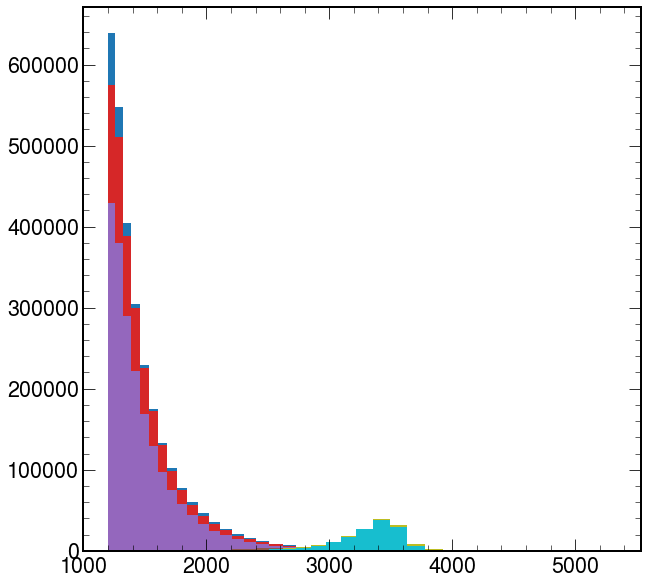

In [48]:
#bin_centers, hist_data = read_root_hist_data(file_name_root_hist)
bin_centers, hist_data = read_raw_selection_data_to_numpy_hist(quants, ae_run_n, qr_run_n, sample_id_sig, xsec_train, bin_edges, paths)

In [49]:
quants

[0.0, 0.3, 0.5, 0.7, 0.9]

## plot histograms

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc10-opt/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


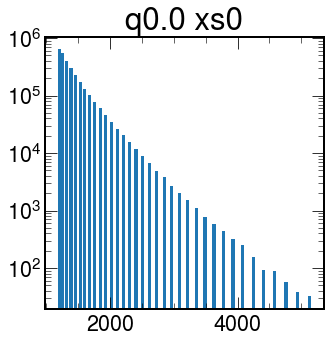

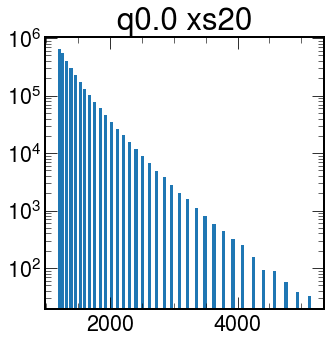

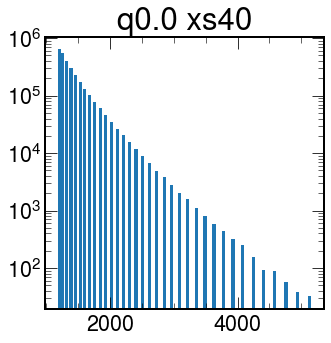

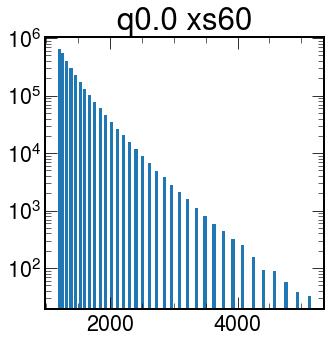

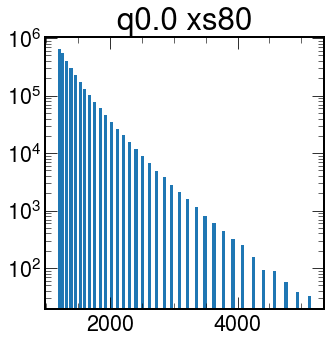

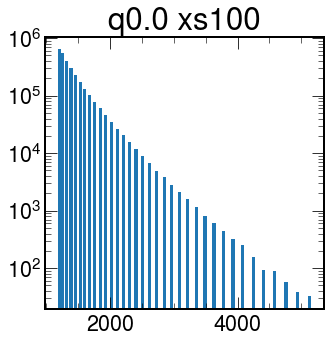

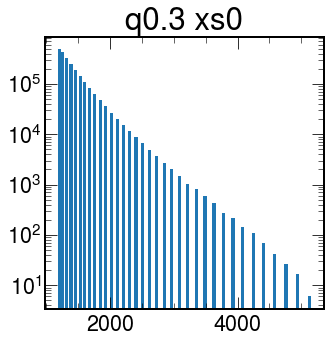

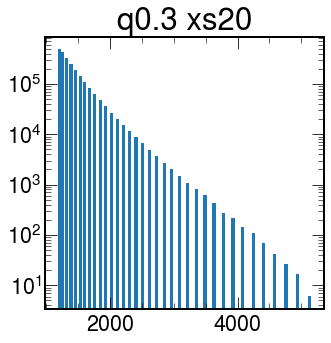

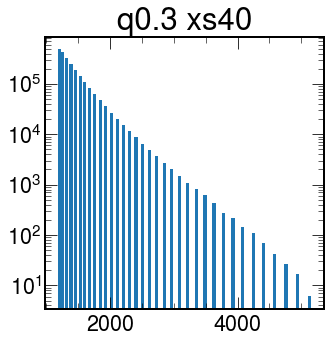

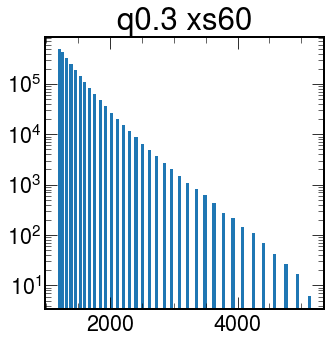

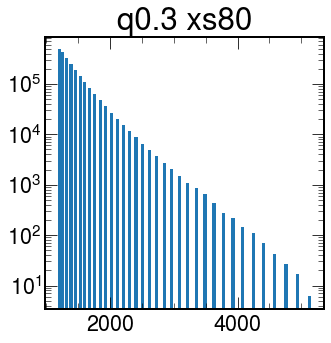

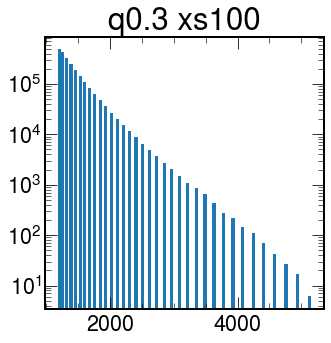

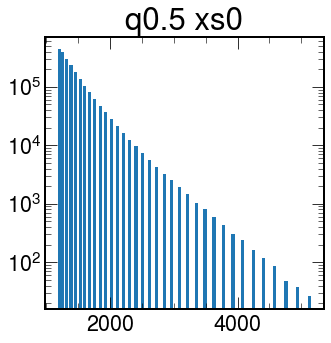

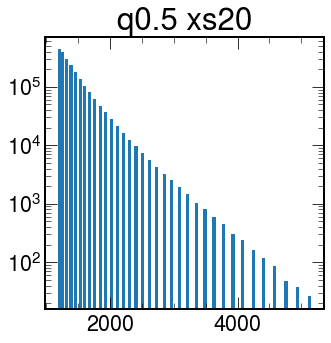

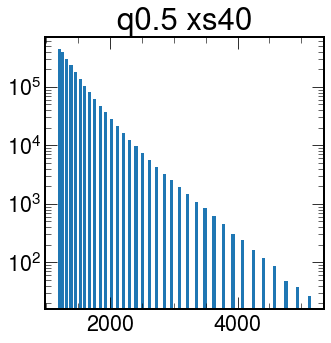

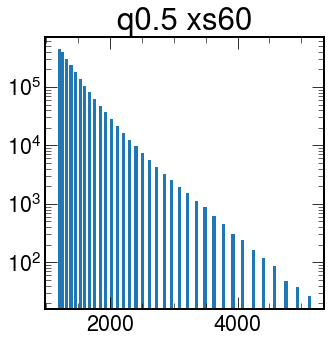

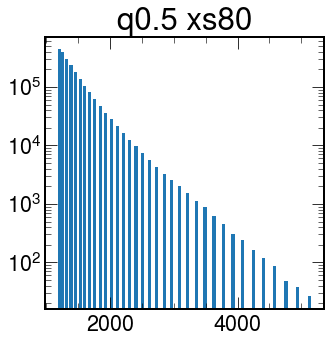

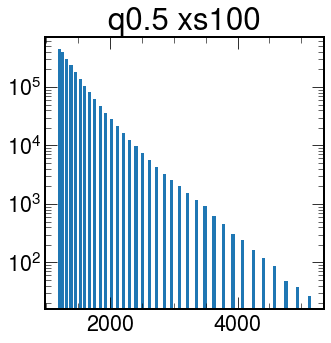

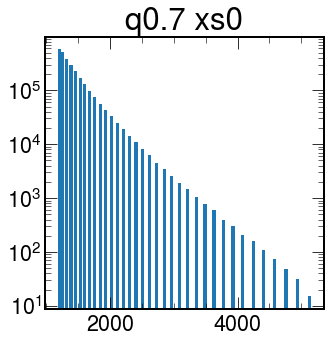

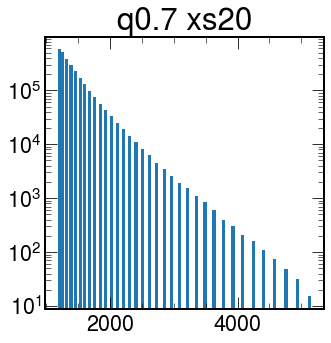

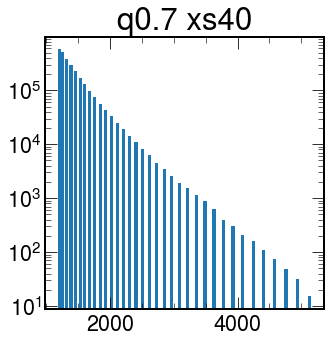

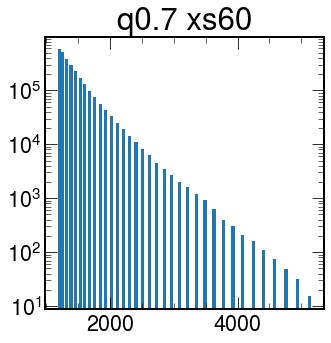

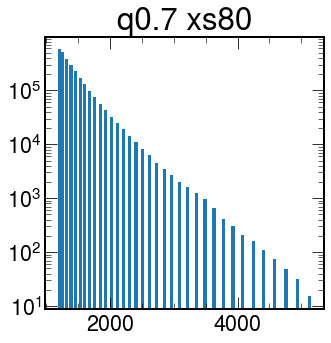

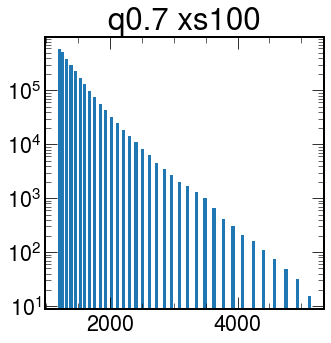

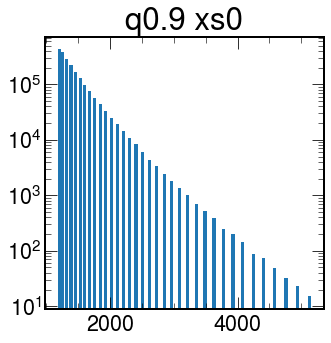

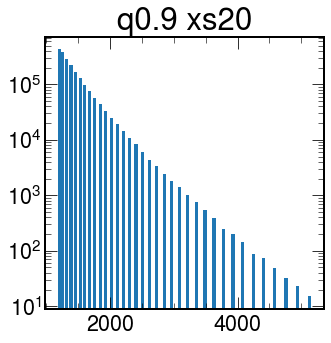

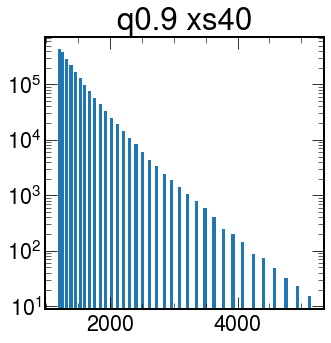

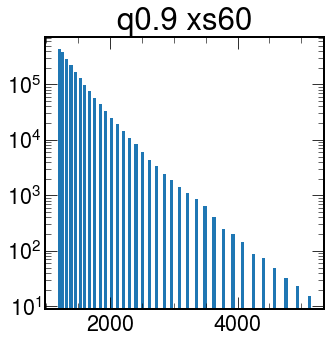

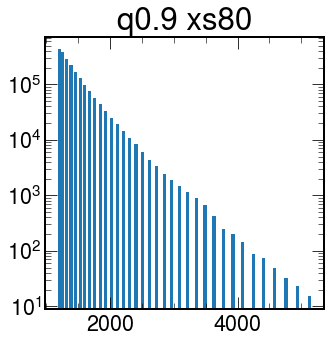

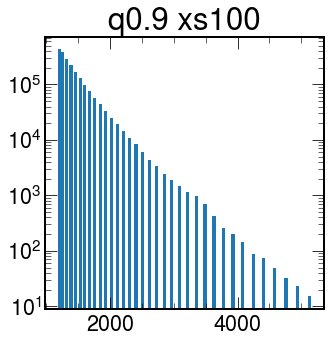

In [50]:
for quant in quants[template_q_idx:]:
    for xsec in xsecs_sig:
        yy = hist_data[quant][xsec]
        plt.figure(figsize=(5, 5))
        plt.bar(bin_centers, yy, width=50, log=True)
        plt.title('q{} xs{}'.format(quant, xsec))

In [51]:
# print N samples
for quant in quants[template_q_idx:]:
    for xsec in xsecs_sig:
        yy = hist_data[quant][xsec]
        print('quant {:>4}, xsec {:>3}: {:>8} events'.format(quant, xsec, int(sum(yy))))

quant  0.0, xsec   0:  2861577 events
quant  0.0, xsec  20:  2861659 events
quant  0.0, xsec  40:  2861742 events
quant  0.0, xsec  60:  2861825 events
quant  0.0, xsec  80:  2861908 events
quant  0.0, xsec 100:  2861991 events
quant  0.3, xsec   0:  2258788 events
quant  0.3, xsec  20:  2258863 events
quant  0.3, xsec  40:  2258939 events
quant  0.3, xsec  60:  2259015 events
quant  0.3, xsec  80:  2259090 events
quant  0.3, xsec 100:  2259166 events
quant  0.5, xsec   0:  2133780 events
quant  0.5, xsec  20:  2133912 events
quant  0.5, xsec  40:  2134045 events
quant  0.5, xsec  60:  2134178 events
quant  0.5, xsec  80:  2134311 events
quant  0.5, xsec 100:  2134444 events
quant  0.7, xsec   0:  2708132 events
quant  0.7, xsec  20:  2708344 events
quant  0.7, xsec  40:  2708556 events
quant  0.7, xsec  60:  2708769 events
quant  0.7, xsec  80:  2708981 events
quant  0.7, xsec 100:  2709194 events
quant  0.9, xsec   0:  2023492 events
quant  0.9, xsec  20:  2023687 events
quant  0.9, 

# Chi Square tests

In [52]:
def chi_square_pearson(observed, expected):
    statistics_per_bin = [(o-e)**2/e for o, e in zip(observed, expected)]
    return sum(statistics_per_bin), statistics_per_bin

In [53]:
def chi_square_neyman(observed, expected):
    statistics_per_bin = [(o-e)**2/max(o,1) for o, e in zip(observed, expected)] # adapted to zero bin counts
    return sum(statistics_per_bin), statistics_per_bin

In [54]:
def chi_square_poisson_likeli(observed, expected):
    statistics_per_bin = [2*(e - o + (o * np.log(o/e) if o else 0)) for o, e in zip(observed, expected)]
    return sum(statistics_per_bin), statistics_per_bin

In [55]:
np.set_printoptions(precision=4, suppress=False)

In [56]:
df = n_bins - 1 # degrees of freedom = number of measurements (=bins) - 1

chi_sq_pearson_stats = {}
chi_sq_neyman_stats = {}
chi_sq_poisson_like = {}

for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    test_stat_xsecs_p = []
    pvals_p = []
    test_stat_xsecs_n = []
    pvals_n = []
    test_stat_xsecs_l = []
    pvals_l = []
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        t_p, _ = chi_square_pearson(observed, expected)
        pval_p = 1 - chi2.cdf(t_p, df=df)
        t_n, _ = chi_square_neyman(observed, expected)
        pval_n = 1 - chi2.cdf(t_n, df=df)
        t_l, _ = chi_square_poisson_likeli(observed, expected)
        pval_l = 1 - chi2.cdf(t_l, df=df)
        test_stat_xsecs_p.append(t_p)
        test_stat_xsecs_n.append(t_n)
        test_stat_xsecs_l.append(t_l)
        pvals_p.append(pval_p)
        pvals_n.append(pval_n)
        pvals_l.append(pval_l)
    
    print('pearson for quantile', quant_test)
    print('ch2:' , np.array(test_stat_xsecs_p))
    print('p-val: ', np.array(pvals_p))
    print('neyman for quantile', quant_test)
    print(np.array(test_stat_xsecs_n))
    print('p-val: ', np.array(pvals_n))
    print('likelihood for quantile', quant_test)
    print(np.array(test_stat_xsecs_l))
    print('p-val: ', np.array(pvals_l))
    print('\n')
    
    chi_sq_pearson_stats[quant_test] = test_stat_xsecs_p
    chi_sq_neyman_stats[quant_test] = test_stat_xsecs_n
    chi_sq_poisson_like[quant_test] = test_stat_xsecs_l

pearson for quantile 0.3
ch2: [67268.6773 67270.2266 67272.1    67274.2913 67276.7944 67279.6036]
p-val:  [0. 0. 0. 0. 0. 0.]
neyman for quantile 0.3
[56244.5213 56245.9454 56247.6181 56249.5298 56251.6713 56254.0341]
p-val:  [0. 0. 0. 0. 0. 0.]
likelihood for quantile 0.3
[63244.01   63245.5444 63247.3747 63249.4932 63251.8926 63254.5657]
p-val:  [0. 0. 0. 0. 0. 0.]


pearson for quantile 0.5
ch2: [34881.283  34946.3675 35014.1768 35084.6569 35157.7553 35233.4207]
p-val:  [0. 0. 0. 0. 0. 0.]
neyman for quantile 0.5
[29681.5822 29719.6512 29758.5911 29798.3441 29838.8579 29880.0848]
p-val:  [0. 0. 0. 0. 0. 0.]
likelihood for quantile 0.5
[32988.8101 33042.5845 33098.2173 33155.6422 33214.7963 33275.6204]
p-val:  [0. 0. 0. 0. 0. 0.]


pearson for quantile 0.7
ch2: [340105.343  340240.4908 340387.8619 340547.2114 340718.3013 340900.9003]
p-val:  [0. 0. 0. 0. 0. 0.]
neyman for quantile 0.7
[238083.767  238162.1518 238244.1617 238329.3807 238417.4587 238508.0983]
p-val:  [0. 0. 0. 0. 0. 0.

### draw test statistics on chi-square distribution graph

saving fig to  fig/vae_run_113/qr_run_191/sig_GtoWW35naReco/xsec_0/loss_rk5_05/hypothesis_testing/chi_square_Pearson.png
saving fig to  fig/vae_run_113/qr_run_191/sig_GtoWW35naReco/xsec_0/loss_rk5_05/hypothesis_testing/chi_square_Neyman.png
saving fig to  fig/vae_run_113/qr_run_191/sig_GtoWW35naReco/xsec_0/loss_rk5_05/hypothesis_testing/chi_square_Poisson Like.png


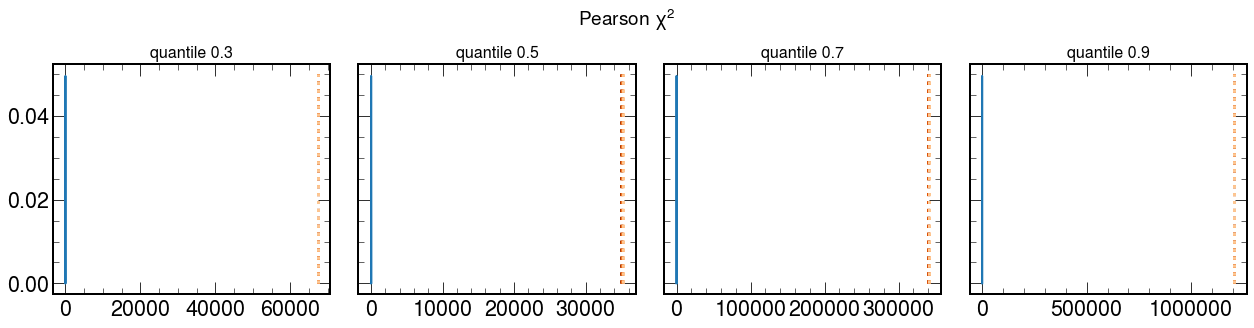

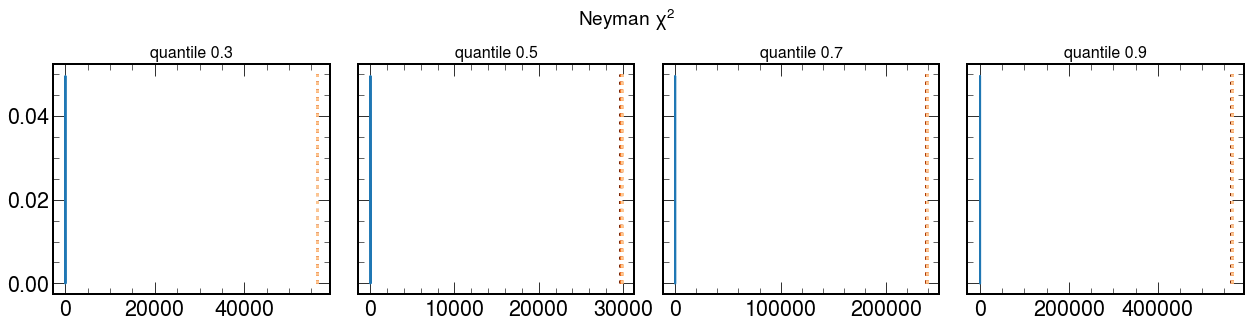

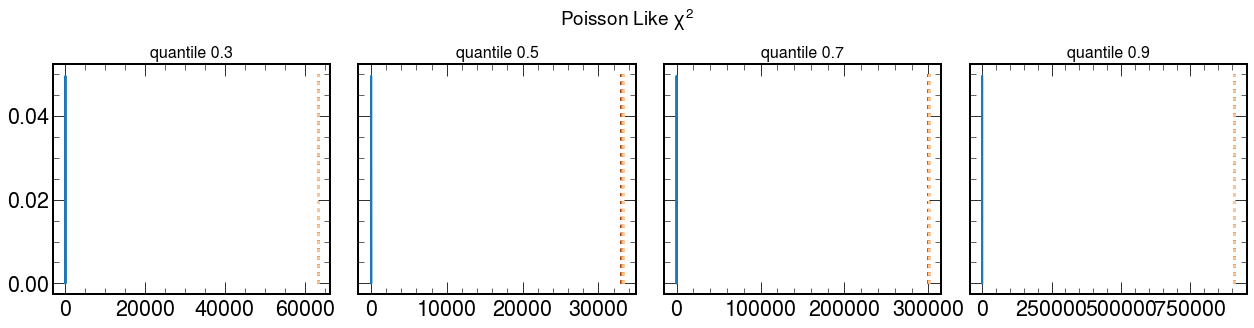

In [57]:
chi_sq_results = {
    'Pearson': chi_sq_pearson_stats,
    'Neyman' : chi_sq_neyman_stats,
    'Poisson Like': chi_sq_poisson_like
}

x = np.arange(0, df*2, 0.001)
cmap = cm.get_cmap('Oranges')
cmap = cmap(np.linspace(0.0, 1.0, len(xsecs_sig)+2))[::-1]

for method, val_dict in chi_sq_results.items():
    fig, axs = plt.subplots(1,len(quants)-1,sharey=True,figsize=(18,5))
    for quant, ax in zip(quants[template_q_idx+1:],axs.flat):
        chi_sq_vals = val_dict[quant]
        ax.plot(x, chi2.pdf(x, df=df), lw=2) # df = num-observed - 1
        ax.vlines(chi_sq_vals,colors=cmap,ymin=0,ymax=0.05, ls=':',lw=3)
        ax.set_title('quantile {}'.format(quant), fontsize=16)
    fig.suptitle(r'{} $\chi^2$'.format(method), fontsize=19)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_path = os.path.join(paths.out_data_dir,'chi_square_{}.png'.format(method))
    print('saving fig to ', fig_path)
    plt.savefig(fig_path)

In [58]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    test_stat_xsecs_p = []
    test_stat_xsecs_n = []
    for xsec in [xsecs_sig[0]]:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        print('\nquant ' +str(quant_test)+', xsec '+ str(xsec))
        print('obs')
        print(np.array(observed))
        print('total events ' + str(sum(observed)))
        print('exp')
        print(np.array(expected))


quant 0.3, xsec 0
obs
[4.8396e+05 4.2836e+05 3.2425e+05 2.4817e+05 1.8707e+05 1.4379e+05
 1.0812e+05 8.2222e+04 6.2166e+04 4.7080e+04 3.5757e+04 2.6765e+04
 2.0428e+04 1.5350e+04 1.1661e+04 8.6640e+03 6.5450e+03 4.8160e+03
 3.7100e+03 2.6470e+03 2.0470e+03 1.4490e+03 1.0430e+03 8.0100e+02
 5.9900e+02 4.2100e+02 2.7500e+02 2.1800e+02 1.4200e+02 1.1000e+02
 6.8000e+01 4.2000e+01 2.7000e+01 1.7000e+01 6.0000e+00]
total events 2258788.0
exp
[4.2585e+05 3.6539e+05 2.6967e+05 2.0323e+05 1.5252e+05 1.1636e+05
 8.8461e+04 6.7757e+04 5.1952e+04 3.9934e+04 3.0709e+04 2.3327e+04
 1.7817e+04 1.3597e+04 1.0258e+04 7.9580e+03 5.8873e+03 4.4260e+03
 3.1973e+03 2.5500e+03 1.8180e+03 1.3660e+03 1.0353e+03 7.3667e+02
 5.2467e+02 3.9200e+02 2.9333e+02 2.1400e+02 1.6667e+02 1.0333e+02
 6.2000e+01 6.0000e+01 3.7333e+01 2.5333e+01 2.1333e+01]

quant 0.5, xsec 0
obs
[4.3841e+05 3.9383e+05 3.0178e+05 2.3487e+05 1.7838e+05 1.3770e+05
 1.0450e+05 8.0403e+04 6.2081e+04 4.7107e+04 3.6495e+04 2.7765e+04
 2.1270e+

In [26]:
dat_tmplt = hist_data[quant_tmplt]

In [27]:
for quant, eff in zip(quants[template_q_idx+1:], effs):
    dat = hist_data[quant]
    p_vals = [scipy.stats.chisquare(f_obs=dat[xsec], f_exp=dat_tmplt[xsec]*eff, axis=0).pvalue for xsec in xsecs_sig]
    print('pvals for quantile {}'.format(quant))
    print(xsecs_sig)
    print(np.asarray(p_vals))

pvals for quantile 0.3
[0, 20, 40, 60, 80, 100]
[0. 0. 0. 0. 0. 0.]
pvals for quantile 0.5
[0, 20, 40, 60, 80, 100]
[0. 0. 0. 0. 0. 0.]
pvals for quantile 0.7
[0, 20, 40, 60, 80, 100]
[0. 0. 0. 0. 0. 0.]
pvals for quantile 0.9
[0, 20, 40, 60, 80, 100]
[0. 0. 0. 0. 0. 0.]


In [28]:
quant_test = 0.5
xsec = 0
eff = effs[quants.index(quant_test)-1]#0.2/0.3 # 30% bottom quantile vs 20% 0.7-0.9 quantile

In [29]:
n_bins

35

In [30]:
eff

0.6666666666666665

In [31]:
# observed
obs = hist_data[quant_test][xsec]

In [32]:
# expected
expt = hist_data[quant_tmplt][xsec]*eff

In [33]:
statistic = 0
for e, o in zip(hist_data[quant_tmplt][xsec]*eff, hist_data[quant_test][xsec]):
    print('obs {}, exp {}, stat {}'.format(o,e,(o-e)**2/e))
    statistic += (o-e)**2/e

obs 473839.0, exp 430964.66666666657, stat 4265.33449481037
obs 417555.0, exp 370434.66666666657, stat 5993.83916582084
obs 314611.0, exp 274006.6666666666, stat 6017.050261956331
obs 240740.0, exp 207178.66666666663, stat 5436.675084521801
obs 180071.0, exp 156070.66666666663, stat 3690.7383841792594
obs 137306.0, exp 119529.99999999997, stat 2643.5721241529413
obs 102733.0, exp 91345.33333333331, stat 1419.6560172142883
obs 78169.0, exp 70216.66666666666, stat 900.6352543713924
obs 59725.0, exp 54063.999999999985, stat 592.758970849367
obs 44761.0, exp 41695.33333333332, stat 225.40441243091604
obs 34245.0, exp 32115.999999999993, stat 141.133422593101
obs 25729.0, exp 24383.999999999996, stat 74.18901738845186
obs 19613.0, exp 18617.999999999996, stat 53.17569019228743
obs 14957.0, exp 14215.33333333333, stat 38.69550094577093
obs 11187.0, exp 10700.666666666664, stat 22.103306128382673
obs 8626.0, exp 8276.666666666664, stat 14.744314673110694
obs 6547.0, exp 6086.666666666665, sta

In [34]:
statistic

31856.543880672893

In [35]:
scipy.stats.chisquare(f_obs=hist_data[quant_test][xsec], f_exp=hist_data[quant_tmplt][xsec]*eff, axis=0)

Power_divergenceResult(statistic=31856.54388067288, pvalue=0.0)

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc10-opt/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'dense_kfold_binned_ratio model, 0.0-0.3 template quantile')

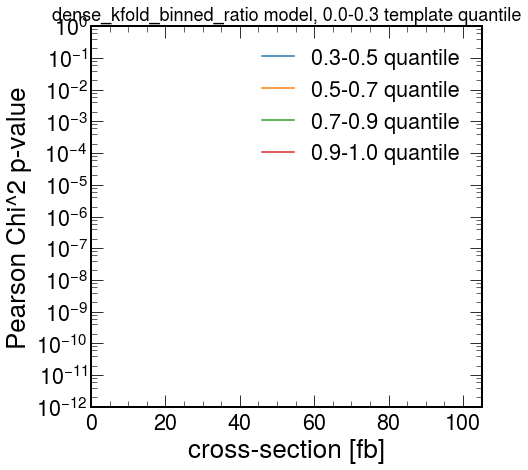

In [36]:
fig = plt.figure(figsize=(7, 7)) # figsize=(5, 5)
# Load CMS style sheet
plt.style.use(hep.style.CMS)
# define color palett for pvalue plotting
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                    '#bcbd22', '#17becf']    


for quant, eff, c in zip(quants[template_q_idx+1:], effs, palette):
    
    dat = hist_data[quant]
    p_vals = [scipy.stats.chisquare(f_obs=dat[xsec], f_exp=dat_tmplt[xsec]*eff, axis=0).pvalue for xsec in xsecs_sig]
        
    label = '{}-{} quantile'.format((quants+['1.0'])[quants.index(quant)], (quants+['1.0'])[quants.index(quant)+1])
    plt.semilogy(xsecs_sig, p_vals, color=c, label=label)
    
plt.legend(loc='best')
plt.xlabel('cross-section [fb]')
plt.ylabel('Pearson Chi^2 p-value')
plt.ylim(bottom=1e-12, top=1)
plt.xlim(left=0)

# set yticks manually
plt.gca().tick_params(direction='in', which='both')
plt.gca().minorticks_on()
locmaj = mpl.ticker.LogLocator(base=10, numticks=15) 
plt.gca().yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=15)
plt.gca().yaxis.set_minor_locator(locmin)
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

plt.title('{} model, {}-{} template quantile'.format(qr_model_str,quants[template_q_idx],quants[template_q_idx+1]), fontsize=18)

    #plt.title('{} model, {}-{} template q, {}-{:.2f} test q {} binning'.format(qr_model_str,quants[template_q_idx+1],quants[template_q_idx], (quants+['0.0'])[quants.index(quant)+1], (quants+['0.0'])[quants.index(quant)], 'dijet' if dijet_binning else 'linear' ))

### poisson likelihood pval

Text(0.5, 1.0, 'dense_kfold_lmfit11_expobin model, 0.0-0.3 template quantile')

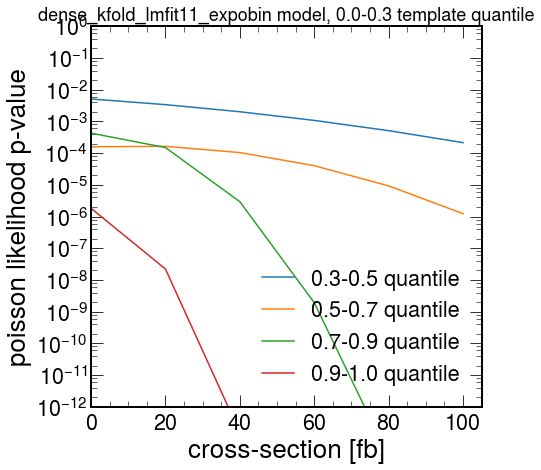

In [141]:
fig = plt.figure(figsize=(7, 7)) # figsize=(5, 5)
# Load CMS style sheet
plt.style.use(hep.style.CMS)
# define color palett for pvalue plotting
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                    '#bcbd22', '#17becf']    


for quant, eff, c in zip(quants[template_q_idx+1:], effs, palette):
    
    dat = hist_data[quant]
    
    p_vals = []
    
    for xsec in xsecs_sig:
    
        t_l, _ = chi_square_poisson_likeli(dat[xsec], dat_tmplt[xsec]*eff)
        pval_l = 1 - chi2.cdf(t_l, df=df)
        p_vals.append(pval_l)
        
    label = '{}-{} quantile'.format((quants+['1.0'])[quants.index(quant)], (quants+['1.0'])[quants.index(quant)+1])
    plt.semilogy(xsecs_sig, p_vals, color=c, label=label)
    
plt.legend(loc='best')
plt.xlabel('cross-section [fb]')
plt.ylabel('poisson likelihood p-value')
plt.ylim(bottom=1e-12, top=1)
plt.xlim(left=0)

# set yticks manually
plt.gca().tick_params(direction='in', which='both')
plt.gca().minorticks_on()
locmaj = mpl.ticker.LogLocator(base=10, numticks=15) 
plt.gca().yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=15)
plt.gca().yaxis.set_minor_locator(locmin)
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

plt.title('{} model, {}-{} template quantile'.format(qr_model_str,quants[template_q_idx],quants[template_q_idx+1]), fontsize=18)

    #plt.title('{} model, {}-{} template q, {}-{:.2f} test q {} binning'.format(qr_model_str,quants[template_q_idx+1],quants[template_q_idx], (quants+['0.0'])[quants.index(quant)+1], (quants+['0.0'])[quants.index(quant)], 'dijet' if dijet_binning else 'linear' ))

## Kolmogorov-Smirnov 2-sample test

In [37]:
# empirical CDF
def ecdf(pdf):
    cdf = np.cumsum(pdf)
    return cdf / cdf[-1]

In [38]:
def kolmogorov_smirnov(observed, expected):
    obs_cdf = ecdf(observed)
    exp_cdf = ecdf(expected)
    return max(abs(obs_cdf-exp_cdf))

In [39]:
def pval_ks(ks_t, n, m):
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    en = m * n / (m + n)
    return kstwo.sf(ks_t, np.round(en))

In [40]:
ks_stats = {}

for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    test_stat_xsecs_ks = []
    pvals_ks = []
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        n, m = float(np.sum(observed)), float(np.sum(expected))
        t_ks = kolmogorov_smirnov(observed, expected)
        p_ks = pval_ks(t_ks, n, m)
        
        test_stat_xsecs_ks.append(t_ks)
        pvals_ks.append(p_ks)
    
    print('KS for quantile', quant_test)
    print('t:' , np.array(test_stat_xsecs_ks))
    print('p-val: ', np.array(pvals_ks))
    print('\n')
    
    ks_stats[quant_test] = test_stat_xsecs_ks

KS for quantile 0.3
t: [0.0018 0.0018 0.0018 0.0018 0.0018 0.0018]
p-val:  [0.0009 0.0008 0.0008 0.0007 0.0007 0.0007]


KS for quantile 0.5
t: [0.0009 0.0009 0.0009 0.001  0.001  0.001 ]
p-val:  [0.2692 0.2521 0.2357 0.2202 0.2055 0.1915]


KS for quantile 0.7
t: [0.0013 0.0013 0.0014 0.0014 0.0015 0.0015]
p-val:  [0.0364 0.0271 0.02   0.0146 0.0105 0.0075]


KS for quantile 0.9
t: [0.0031 0.0031 0.0032 0.0032 0.0033 0.0033]
p-val:  [2.3796e-05 1.6049e-05 1.0753e-05 7.1572e-06 4.7325e-06 3.1086e-06]




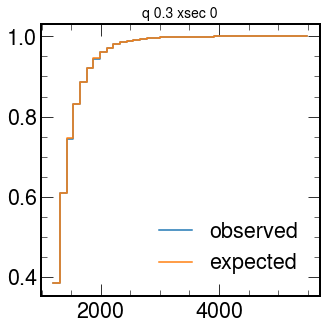

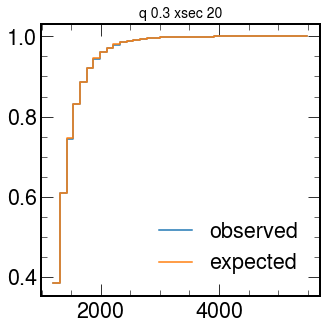

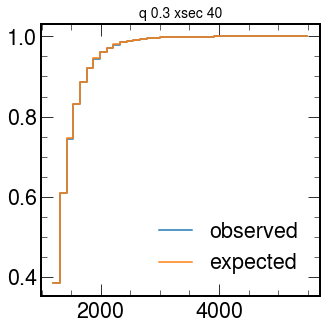

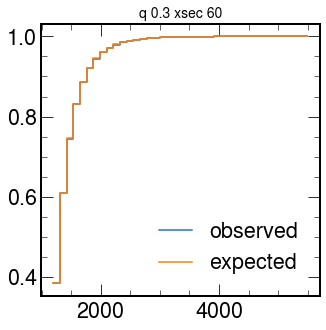

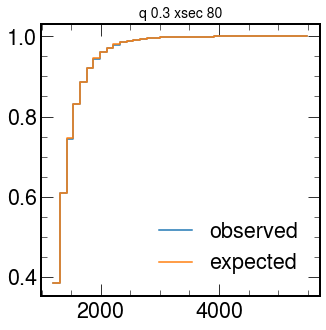

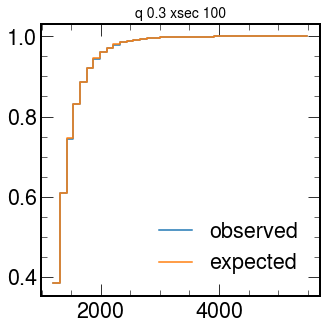

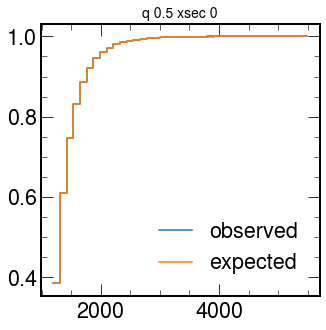

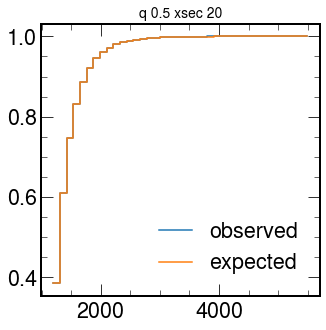

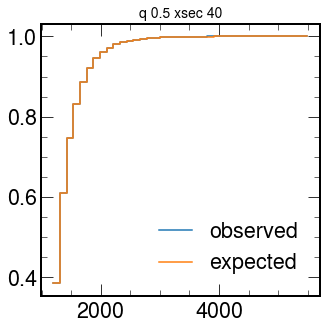

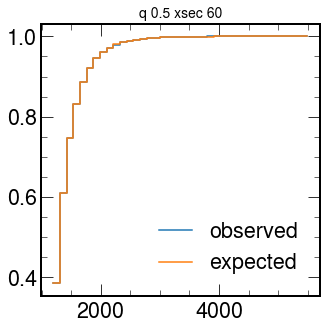

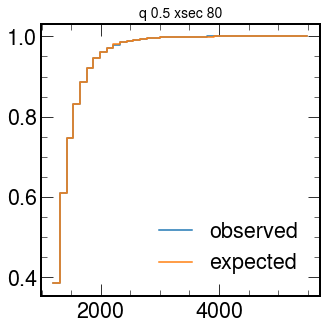

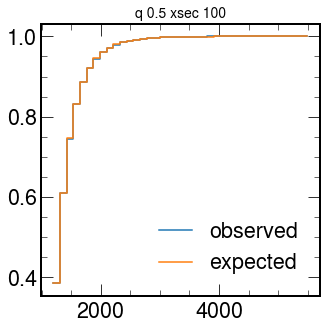

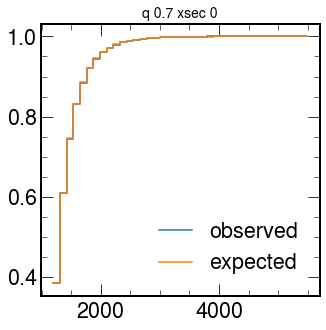

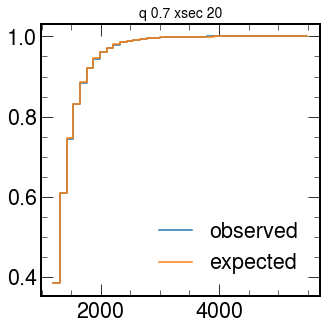

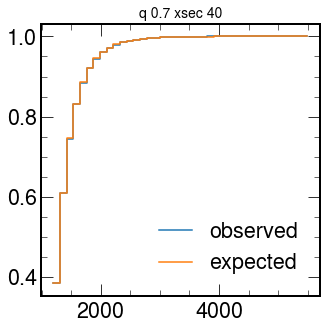

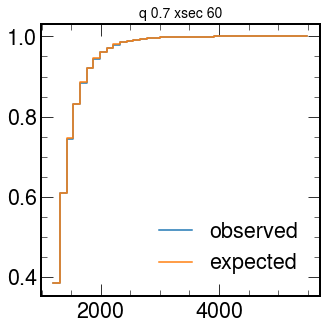

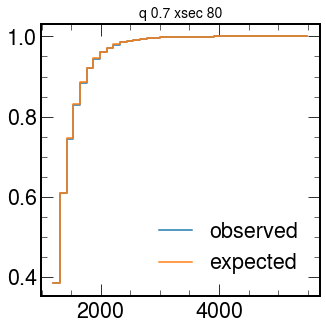

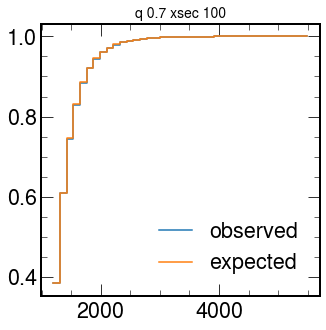

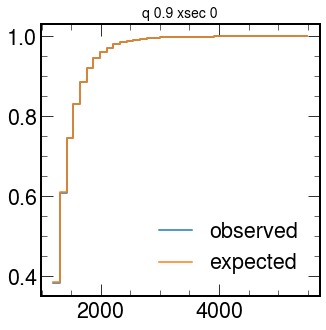

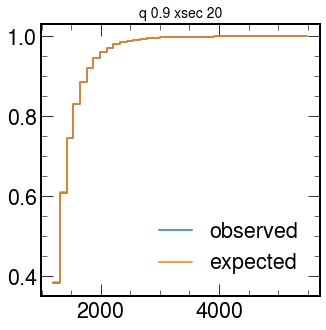

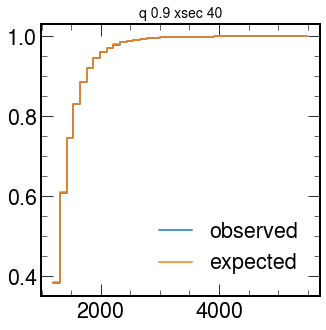

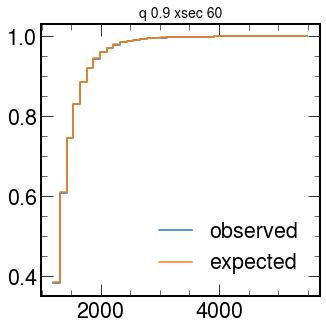

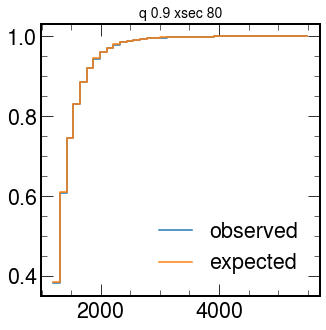

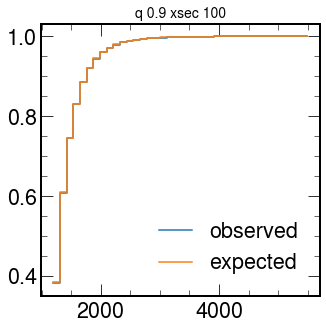

In [41]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        obs_ecdf = ecdf(observed)
        exp_ecdf = ecdf(expected)
        
        fig = plt.figure(figsize=(5,5))
        plt.plot(bin_edges[:-1], obs_ecdf, label='observed', drawstyle='steps-post')
        plt.plot(bin_edges[:-1], exp_ecdf, label='expected', drawstyle='steps-post')
        plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
        plt.legend(loc='best')
        plt.show()


## KS from pdfs

In [42]:
mjj_vals_qcd, mjj_vals_sig = read_raw_selection_data(quants, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths)

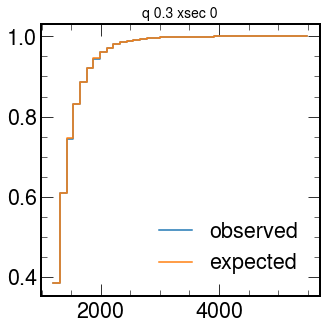

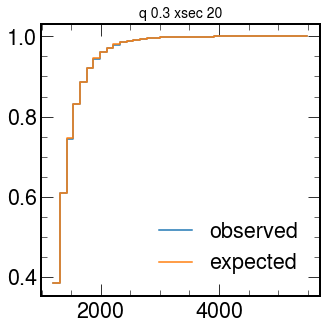

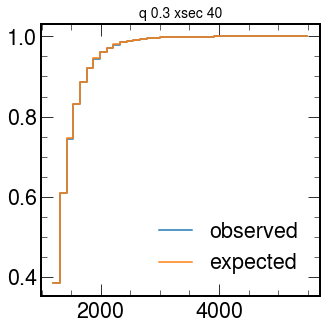

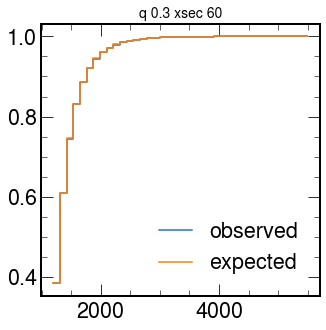

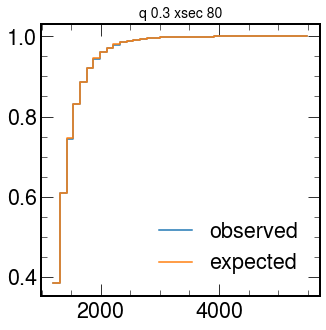

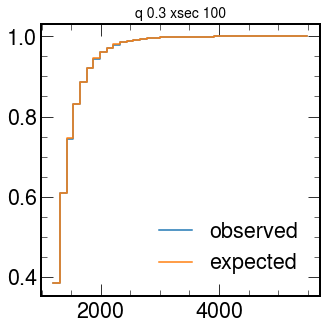

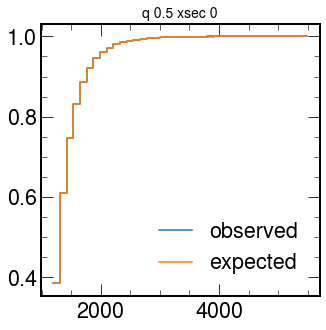

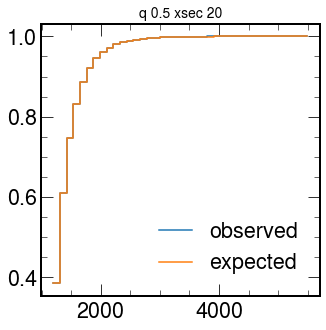

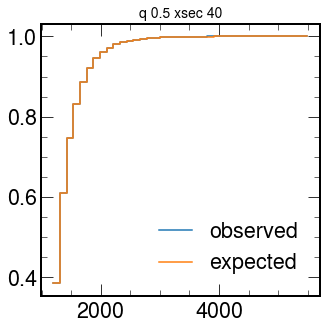

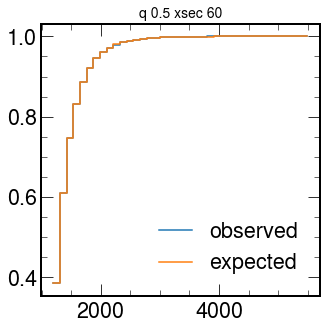

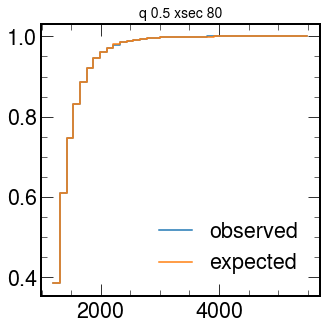

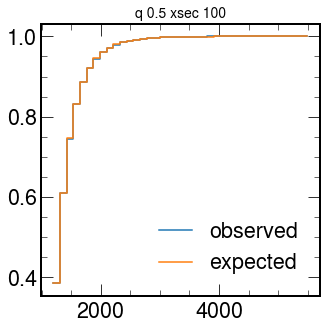

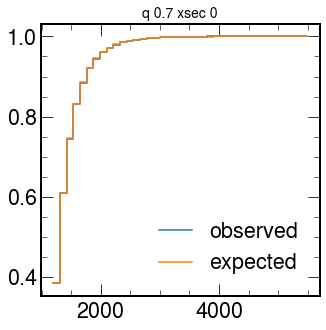

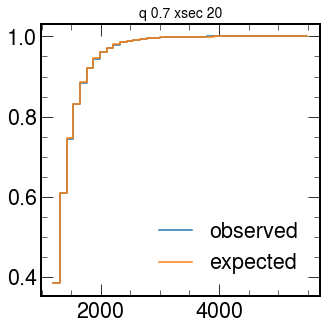

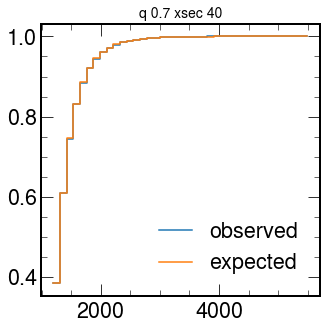

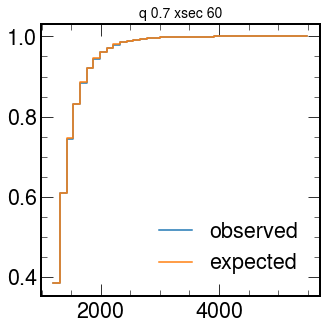

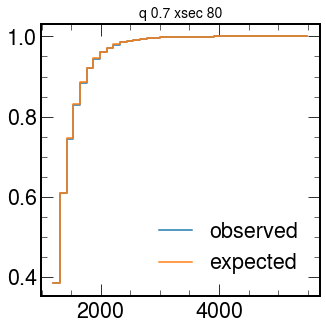

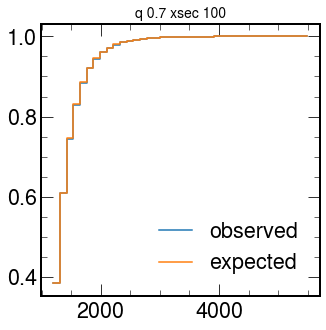

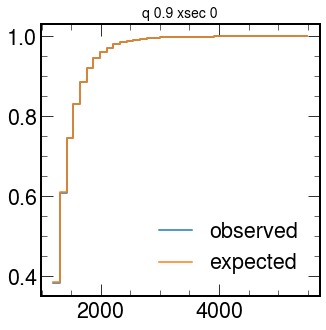

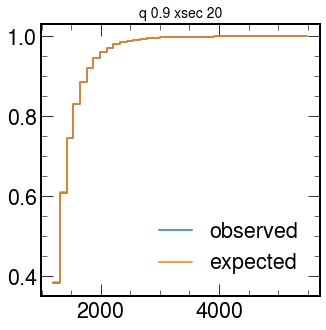

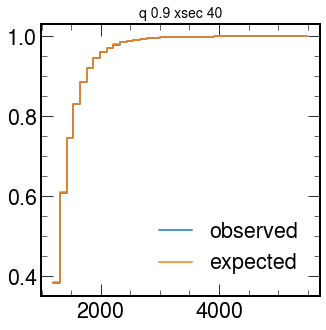

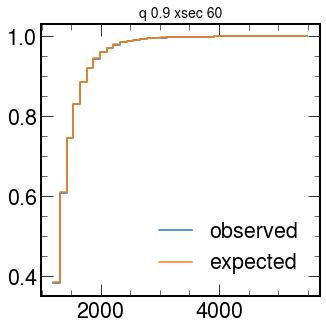

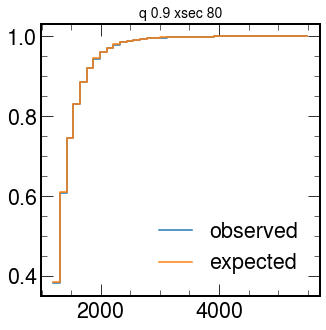

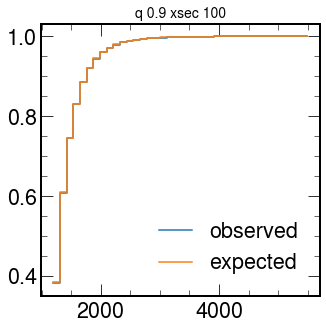

In [43]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        obs_ecdf = ecdf(observed)
        exp_ecdf = ecdf(expected)
        
        fig = plt.figure(figsize=(5,5))
        plt.plot(bin_edges[:-1], obs_ecdf, label='observed', drawstyle='steps-post')
        plt.plot(bin_edges[:-1], exp_ecdf, label='expected', drawstyle='steps-post')
        plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
        plt.legend(loc='best')
        plt.show()


In [44]:
len(mjj_vals_sig)

5

In [45]:
def get_ks_test_stat_pval(data1, data2):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    data_all = np.concatenate([data1, data2])
    # using searchsorted solves equal data problem
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2
    t_ks = np.max(np.abs(cdf1 - cdf2))
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    prob = kstwo.sf(t_ks, np.round(en))
    return t_ks, prob

In [46]:
def get_ks_test_stat_pval_from_cdf(cdf1, cdf2, n1, n2):
    t_ks = np.max(np.abs(cdf1 - cdf2))
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    prob = kstwo.sf(t_ks, np.round(en))
    return t_ks, prob

In [47]:
s1 = np.random.normal(size=100000)
s2 = np.random.normal(size=100000)

In [48]:
from scipy import stats
stats.ks_2samp(s1, s2)

KstestResult(statistic=0.005850000000000022, pvalue=0.06502080234332397)

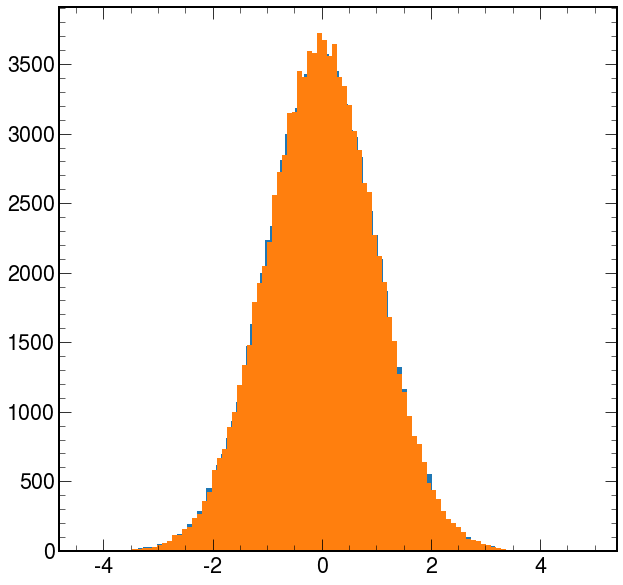

In [49]:
counts1, _, _ = plt.hist(s1, bins=100)
counts2, _, _ = plt.hist(s2, bins=100)
n1, n2 = float(len(s1)), float(len(s2))
cdf1 = np.cumsum(counts1)
cdf1 = cdf1 / cdf1[-1]
cdf2 = np.cumsum(counts2)
cdf2 = cdf2 / cdf2[-1]
t_ks, p_ks = get_ks_test_stat_pval_from_cdf(cdf1, cdf2, n1, n2)

In [50]:
print(t_ks, p_ks)

0.09639000000000003 0.0


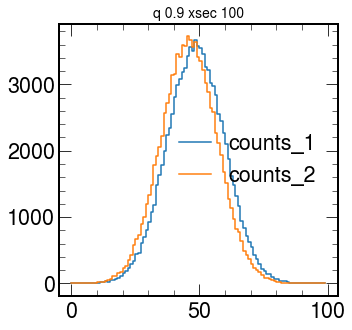

In [51]:
fig = plt.figure(figsize=(5,5))
plt.plot(counts1, label='counts_1', drawstyle='steps-post')
plt.plot(counts2, label='counts_2', drawstyle='steps-post')
plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
plt.legend(loc='best')
plt.show()

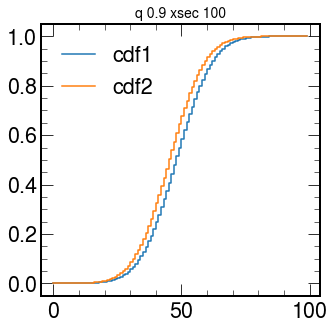

In [52]:
fig = plt.figure(figsize=(5,5))
plt.plot(cdf1, label='cdf1', drawstyle='steps-post')
plt.plot(cdf2, label='cdf2', drawstyle='steps-post')
plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
plt.legend(loc='best')
plt.show()

In [53]:
s1 = np.random.normal(loc=1, size=10000)
s2 = np.random.normal(loc=2, size=100)

In [54]:
stats.ks_2samp(s1, s2)

KstestResult(statistic=0.379, pvalue=2.7766677845875165e-13)

In [55]:
s1 = np.random.normal(scale=1, size=10000)
s2 = np.random.normal(scale=2, size=100)
stats.ks_2samp(s1, s2)

KstestResult(statistic=0.207, pvalue=0.0003385066199647069)